# Training allosteric flow networks with Coupled Learning
Begin by importing a few packages:

In [1]:
import sys
sys.path.append('../coupled_learning/')
from circuit_utils import *
from network_utils import *
from cl_utils import *
import matplotlib.pyplot as plt
from packing_utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Create a graph object represeing the network. Here we use jammed packing networks. 

It is also possible to input a JSON file with graph data. For more options see the network_utils package.

In [2]:
g = jammed_network(100, seed = 1)

progress: 100%|##########| 1000.00/1000.00 [00:04<00:00]


Set the initial conductance values, the learning rate, and initialize the allosteric network object.

In [3]:
initial_conductances = np.ones(g.number_of_edges())
lr = 0.1
allo = CL(g, initial_conductances, learning_rate=lr)

Visualize the linear flow network

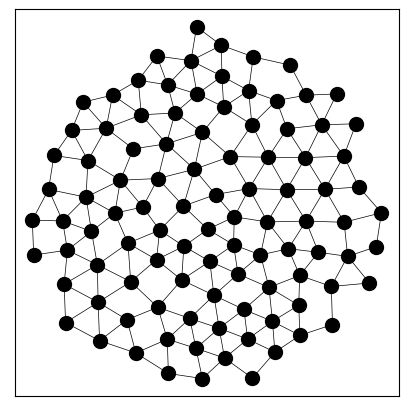

In [4]:
allo.plot_circuit(highlight_nodes=False)

Visualize the conductance values

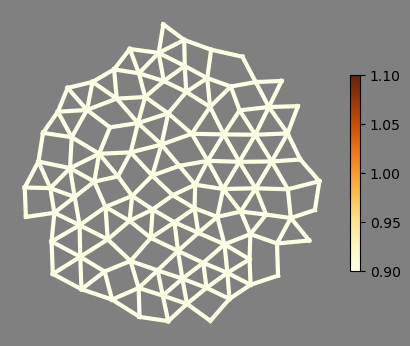

In [5]:
allo.plot_edge_state(allo.conductances, lw = 3, background_color='0.5')

## Define the task

There are several tasks a flow network can accomplish. Here we showcase the case of node allostery.

The workflow is the following:
1. Define the source nodes by their names (in this case numbers)
2. Find the indices that lead to the previous nodes (sometimes these coincides with the numbering name).
3. Define the input values.

Repeat for the target

Set the task

In [6]:
nodes_source = np.array([0,49,23])
indices_source = np.array([list(allo.graph.nodes).index(node) for node in nodes_source])
inputs_source = np.array([0.,0.5,2.])

nodes_target = np.array([15,43])
indices_target = np.array([list(allo.graph.nodes).index(node) for node in nodes_target])
inputs_target = np.array([0.4,0.9])

_ = allo.set_task(indices_source, inputs_source, indices_target, inputs_target)

Plot the network highlighting the sources (red) and targets (blue)

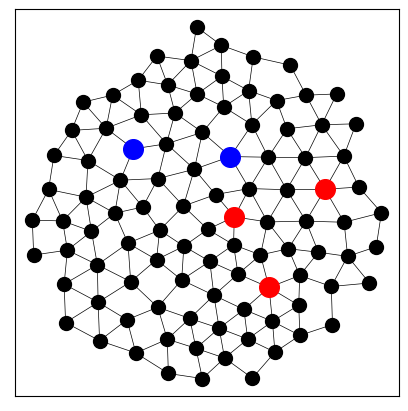

In [7]:
allo.plot_circuit(highlight_nodes=True)

## Training
To train, set the conductances, define the number of epochs, the number of iterations per epoch and the nudge.

In addition there are several optional arguments for showcasing the training and saving data.

In [8]:
allo.setConductances(initial_conductances)
n_epochs = 10
n_steps_per_epoch = 10
eta = 0.1

_,_,_,_,_ = allo.train(n_epochs, n_steps_per_epoch, eta = eta, verbose = False, pbar = True, log_spaced = False, save_state = False)

100%|██████████| 10/10 [00:00<00:00, 52.37it/s]


Visualize the error along training

Text(0.5, 1.0, 'Training loss')

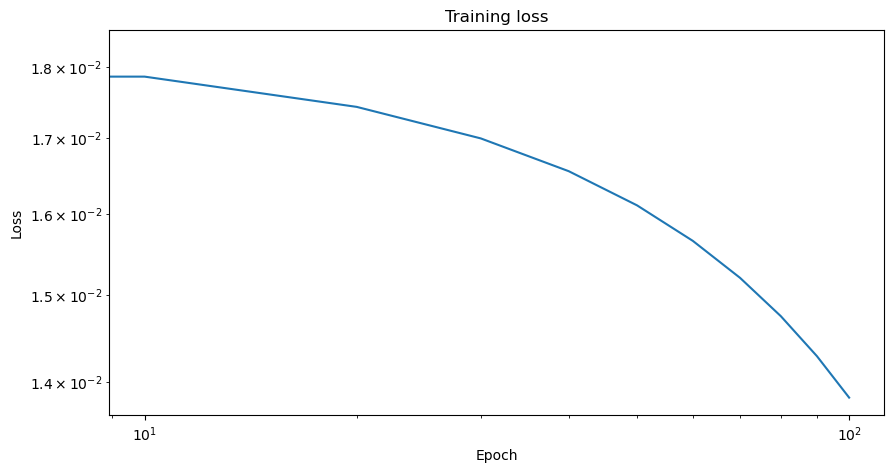

In [9]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
axs.plot(allo.end_epoch,allo.losses)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Epoch')
axs.set_ylabel('Loss')
axs.set_title('Training loss')

Visualize the final state of the system:
1. Conductance values
2. Voltage values in the free state

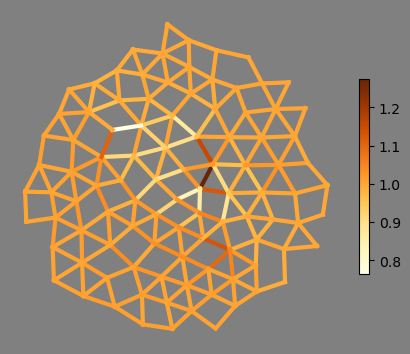

In [10]:
allo.plot_edge_state(allo.conductances, lw = 3, background_color='0.5')

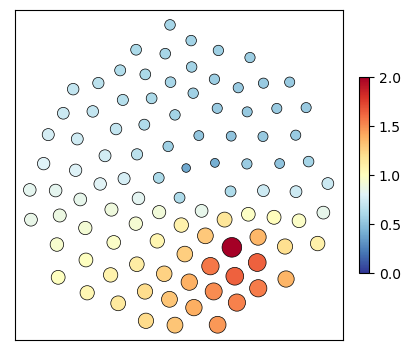

In [11]:
allo.plot_node_state(allo.get_free_state(), cmap = 'RdYlBu_r')

# Saving and Loading
It is also possible to save global information about a network, as well as local information about the conductances along training.

We take the same example as before (resetting the conductances and the initial step), and perform the training with saving options.

The save_global option generates two JSON files:
1. A global.JSON containing all the hyperparameters of the network as well as scalar quantities saved along training.
2. A graph.JSON containing all the information of the graph.

The save_state option generates a CSV file containing all the conductances at each epoch of training.



In [12]:
allo.reset_training()
allo.setConductances(initial_conductances)
n_epochs = 10
n_steps_per_epoch = 10
eta = 0.1
name = 'example-network'

_,_,_,_,_ = allo.train(n_epochs, n_steps_per_epoch, eta = eta, verbose = False, pbar = True, log_spaced = False, save_global = True, save_state = True, save_path = name)

100%|██████████| 10/10 [00:00<00:00, 49.18it/s]


We can read the global data and plot the error

Text(0, 0.5, 'Loss')

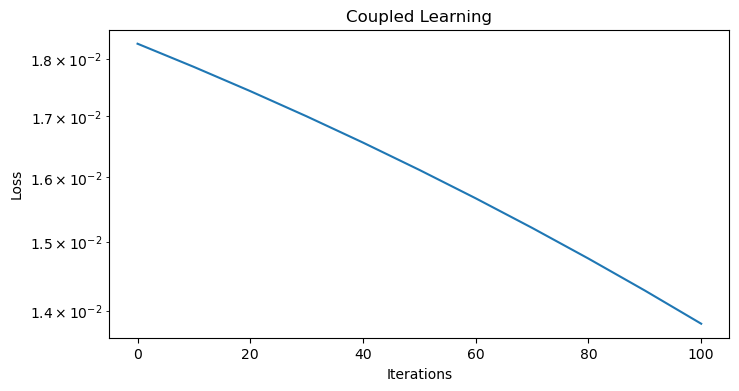

In [13]:
with open('example-network_global.json', 'r') as f:
    data = json.load(f)

fig, axs = plt.subplots(1,1, figsize = (8,4), sharey = True)
axs.plot(data['end_epoch'],
         data['losses'])
axs.set_title('Coupled Learning')
# log scale
axs.set_yscale('log')
axs.set_yscale('log')
# labels
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss')

And read the local data to see, for example, the evolution of the conductances

Text(0.5, 0, 'Iterations')

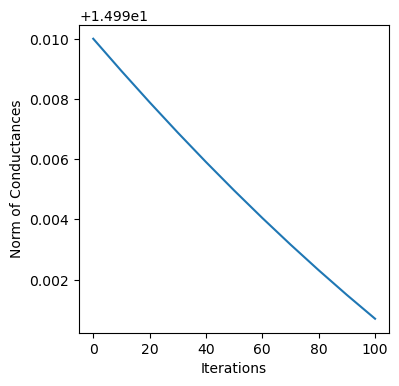

In [14]:
conductancesData = np.array(load_from_csv('example-network.csv'))
norms = np.linalg.norm(conductancesData, axis = 1)



fig, axs = plt.subplots(1,1, figsize = (4,4))
axs.plot(data['end_epoch'],norms)
axs.set_ylabel('Norm of Conductances')
axs.set_xlabel('Iterations')

# Network reconstruction

With the global and local files you can reconstruct a trained network.

Here we read the previous information and create a new object, allo2.

In [15]:
allo2 = CL_from_file('example-network_global.json', 'example-network_graph.json','example-network.csv')

Visualize the network and plot the error

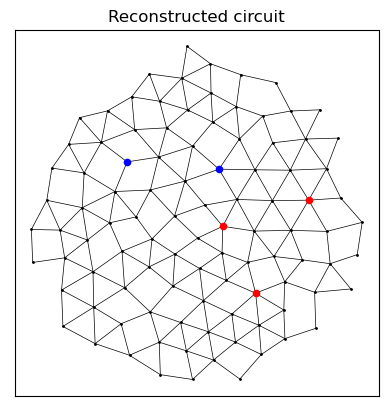

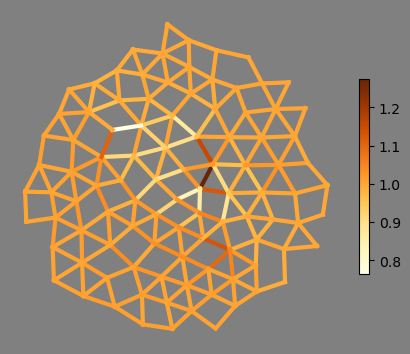

In [16]:
allo2.plot_circuit(title='Reconstructed circuit', lw = 0.5, point_size = 1, highlight_nodes = True, figsize = (4,4), highlighted_point_size = 20, filename = None)
allo2.plot_edge_state(allo2.conductances, lw = 3, background_color='0.5')


Text(0.5, 1.0, 'Training loss')

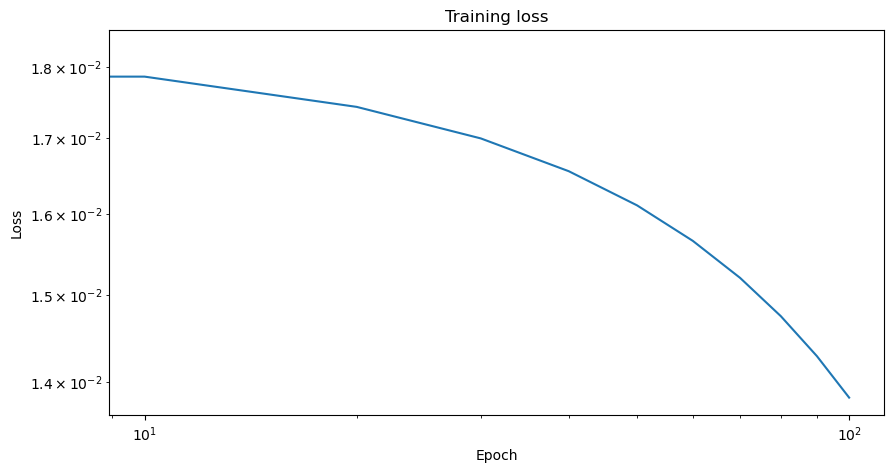

In [17]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
axs.plot(allo2.end_epoch,allo2.losses)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlabel('Epoch')
axs.set_ylabel('Loss')
axs.set_title('Training loss')

# Training Regression flow networks with Coupled Learning

In [23]:
nodes_source = np.array([0,49,23])
indices_source = np.array([list(allo.graph.nodes).index(node) for node in nodes_source])

ntrain = 100
input_xy = np.random.rand(ntrain,2)
inputs_source = np.c_[input_xy, np.zeros(ntrain)]



nodes_target = np.array([15,43])
indices_target = np.array([list(allo.graph.nodes).index(node) for node in nodes_target])
output_target = np.array([np.array([[0.15,0.2],[0.1,0.3]]) @ input_xy[i] for i in range(ntrain)])
_ = allo.set_task(indices_source, inputs_source, indices_target, output_target)

Plot the network highlighting the sources (red) and targets (blue)

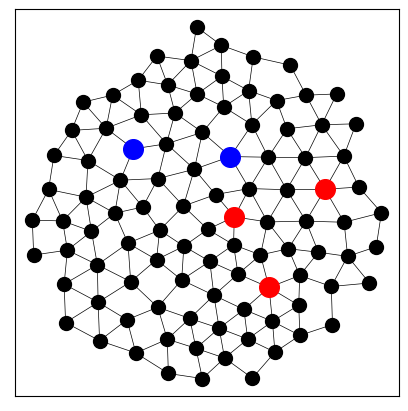

In [24]:
allo.plot_circuit(highlight_nodes=True)

## Training
To train, set the conductances, define the number of epochs, the number of iterations per epoch and the nudge.

In addition there are several optional arguments for showcasing the training and saving data.

In [25]:
allo.setConductances(initial_conductances)
n_epochs = 50
n_steps_per_epoch = 10000
eta = 0.1

_,_,_,_,_ = allo.train(n_epochs, n_steps_per_epoch, eta = eta, batchSize=10, verbose = False, pbar = True, log_spaced = False, save_state = False)

 38%|███▊      | 19/50 [57:20<1:38:41, 191.00s/it]

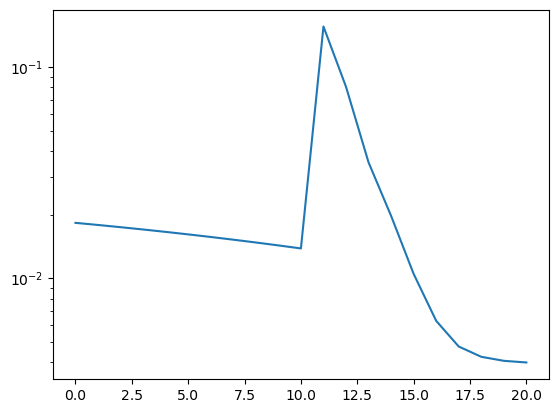

In [ ]:
plt.plot(allo.losses)
plt.yscale('log')